In [192]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D  
import rbf_gauss
from scipy.io import savemat

In [193]:
# Load multisine data from matlab
mat = scipy.io.loadmat("u_data.mat")
u_data = mat["u_data"]

mat = scipy.io.loadmat("y_data.mat")
y_data = mat["y_data"]

# convert data to tensors
u_data = np.array(u_data)
y_data = np.array(y_data)

u_data = torch.FloatTensor(u_data).transpose(0,1)
#u_data = u_data[0,:1000].unsqueeze(0).transpose(0,1)
y_data = torch.FloatTensor(y_data).transpose(0,1)
#y_data = y_data[0,:1000].unsqueeze(0).transpose(0,1)
#y_data = y_data[0,:].unsqueeze(1)
#torch.reshape(y_data,(1000, 1))
input_dim = list(u_data.shape)[1]
output_dim = list(y_data.shape)[1]

In [237]:
# Hyper parameters
T_ini = 20
n_basis = 100
T = 1000
in_features = T_ini * 2
out_features = n_basis
N = 100

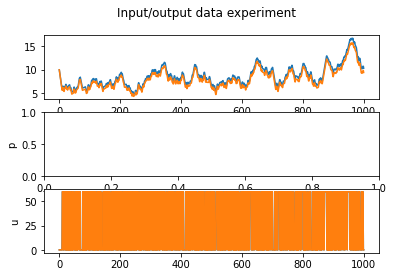

In [238]:
# Plot the pendulum trajectory together with the input
fig, axs = plt.subplots(3)
fig.suptitle("Input/output data experiment")
axs[0].plot(y_data[:,])
#axs[1].plot(y_data[:,1])
axs[2].plot(u_data)
axs[1].set(ylabel="p")
#axs[1].set(ylabel="theta")
axs[2].set(ylabel="u")
plt.show()

In [239]:
U_ini = torch.transpose(u_data[0 : T_ini - 1,0].unsqueeze(1), 0, 1)
U_0_Nm1 = torch.transpose(u_data[T_ini - 1 : T_ini + N - 1,0].unsqueeze(1), 0, 1)
if input_dim > 1:
    for j in range(input_dim-1):
        U_ini = torch.cat((U_ini, torch.transpose(u_data[0 : T_ini - 1,j].unsqueeze(1), 0, 1)),1)
        U_0_Nm1 = torch.cat((U_0_Nm1, torch.transpose(u_data[T_ini - 1 : T_ini + N - 1,1].unsqueeze(1), 0, 1)),1)
# print(f"U_ini = {(U_ini).shape}")           
# print(f"U_0_Nm1 = {(U_0_Nm1).shape}")        

Y_ini = torch.transpose(y_data[1 : T_ini + 1,0].unsqueeze(1), 0, 1)
Y_1_N = torch.transpose(y_data[T_ini + 1 : T_ini + 1 + N,0].unsqueeze(1), 0, 1)
if output_dim > 1:
    for p in range(output_dim-1):
        Y_ini = torch.cat((Y_ini, torch.transpose(y_data[1 : T_ini + 1,p].unsqueeze(1), 0, 1)),1)
        Y_1_N = torch.cat((Y_1_N, torch.transpose(y_data[T_ini + 1 : T_ini + 1 + N,p].unsqueeze(1), 0, 1)),1)

# print(f"Y_ini = {(Y_ini).shape}")           
# print(f"Y_1_N = {(Y_1_N).shape}")       

for i in range(T - T_ini - 1 - N):
    if i < 100:
        print(i)
    U_ini_part =  torch.transpose(u_data[i + 1 : T_ini + i,0].unsqueeze(1), 0, 1)
    U_0_Nm1_part = torch.transpose(u_data[T_ini + i : T_ini + i + N,0].unsqueeze(1), 0, 1)
    if input_dim > 1:
        for j in range(input_dim-1):
            U_ini_part =  torch.cat((U_ini_part, torch.transpose(u_data[i + 1 : T_ini + i,j].unsqueeze(1), 0, 1)), 1)
            U_0_Nm1_part = torch.cat((U_0_Nm1_part ,torch.transpose(u_data[T_ini + i : T_ini + i + N,j].unsqueeze(1), 0, 1)),1)
    
    Y_ini_part =  torch.transpose(y_data[i + 2 : T_ini + 2 + i,0].unsqueeze(1), 0, 1)
    Y_1_N_part = torch.transpose(y_data[T_ini + 2 + i : T_ini + 2 + i + N,0].unsqueeze(1), 0, 1)
    if output_dim > 1:
        for p in range(output_dim-1):
            Y_ini_part =  torch.cat((Y_ini_part, torch.transpose(y_data[i + 2 : T_ini + 2 + i,p].unsqueeze(1), 0, 1)), 1)
            Y_1_N_part = torch.cat((Y_1_N_part ,torch.transpose(y_data[T_ini + 2 + i : T_ini + 2 + i + N,p].unsqueeze(1), 0, 1)),1)
#             print(f"Y_ini_part = {(Y_ini_part).shape}")
#             print(f"Y_1_N_part = {(Y_1_N_part).shape}")
                                   
    U_ini =  torch.cat((U_ini, U_ini_part), 0)        
    U_0_Nm1 = torch.cat((U_0_Nm1,U_0_Nm1_part ))
#     print(f"U_ini = {(U_ini).shape}")
#     print(f"U_0_Nm1 = {(U_0_Nm1).shape}")
    Y_ini = torch.cat((Y_ini, Y_ini_part), 0)
    Y_1_N = torch.cat((Y_1_N, Y_1_N_part), 0)    
#     print(f"Y_ini = {(Y_ini).shape}")
#     print(f"Y_1_N = {(Y_1_N).shape}") 
        
X = torch.cat((U_ini, Y_ini, U_0_Nm1), 1)
y = Y_1_N

print(f"X = {(X).shape}")
print(f"y = {(y).shape}")
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41
)    

print(f"X_train = {(X_train).shape}")
print(f"y = {(y).shape}")
print(f"y_train = {(y_train).shape}")

X_train_1 = X_train[:, 0 : (2 * T_ini - 1)*input_dim]
X_train_2 = X_train[:, (2 * T_ini - 1)*input_dim :]

X_test_1 = X_test[:, 0 : (2 * T_ini - 1)*input_dim]
X_test_2 = X_test[:, (2 * T_ini - 1)*input_dim :] 

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
X = torch.Size([880, 278])
y = torch.Size([880, 200])
X_train = torch.Size([704, 278])
y = torch.Size([880, 200])
y_train = torch.Size([704, 200])


In [228]:


N_training = list(y_data.shape)[0]

print(f"u_data = {(u_data).shape}")
print(f"y_data = {y_data.shape}")

U_ini1 = torch.transpose(u_data[0 : T_ini - 1,0].unsqueeze(1), 0, 1)
U_ini2= torch.transpose(u_data[0 : T_ini - 1,1].unsqueeze(1), 0, 1)
print(f"U_ini1 = {(U_ini1).shape}")
print(f"U_ini2 = {(U_ini2).shape}")
U_0_Nm1_1 = torch.transpose(u_data[T_ini - 1 : T_ini + N - 1,0].unsqueeze(1), 0, 1)
U_0_Nm1_2 = torch.transpose(u_data[T_ini - 1 : T_ini + N - 1,1].unsqueeze(1), 0, 1)

Y_ini1 = torch.transpose(y_data[1 : T_ini + 1,0].unsqueeze(1), 0, 1)
Y_ini2 = torch.transpose(y_data[1 : T_ini + 1,1].unsqueeze(1), 0, 1)

print(f"Y_ini1 = {(Y_ini1).shape}")
print(f"Y_ini2 = {(Y_ini2).shape}")
Y_1_N_1 = torch.transpose(y_data[T_ini + 1 : T_ini + 1 + N,0].unsqueeze(1), 0, 1)
Y_1_N_2 = torch.transpose(y_data[T_ini + 1 : T_ini + 1 + N,1].unsqueeze(1), 0, 1)

for i in range(T - T_ini - 1 - N):
    if i < 100:
        print(i)
    U_ini1 = torch.cat((U_ini1, torch.transpose(u_data[i + 1 : T_ini + i,0].unsqueeze(1), 0, 1)), 0)
    U_ini2 = torch.cat((U_ini2, torch.transpose(u_data[i + 1 : T_ini + i,1].unsqueeze(1), 0, 1)), 0)
    u_loop1 = torch.transpose(u_data[T_ini + i : T_ini + i + N,0].unsqueeze(1), 0, 1)
    u_loop2 = torch.transpose(u_data[T_ini + i : T_ini + i + N,1].unsqueeze(1), 0, 1)
    print(f"u_loop1 = {(u_loop1).shape}")
    print(f"u_loop2 = {(u_loop12).shape}")
    U_0_Nm1_1 = torch.cat((U_0_Nm1_1, u_loop1), 0)
    U_0_Nm1_2 = torch.cat((U_0_Nm1_2, u_loop2), 0)

    print(f" U_0_Nm1_1 = {( U_0_Nm1_1).shape}")
    print(f"U_0_Nm1_2 = {(U_0_Nm1_2).shape}")

    Y_ini1 = torch.cat((Y_ini1, torch.transpose(y_data[i + 2 : T_ini + 2 + i,0].unsqueeze(1), 0, 1)), 0)
    Y_ini2 = torch.cat((Y_ini2, torch.transpose(y_data[i + 2 : T_ini + 2 + i,1].unsqueeze(1), 0, 1)), 0)
    y_loop1 = torch.transpose(y_data[T_ini + 2 + i : T_ini + 2 + i + N,0].unsqueeze(1), 0, 1)
    y_loop2 = torch.transpose(y_data[T_ini + 2 + i : T_ini + 2 + i + N,1].unsqueeze(1), 0, 1)
    Y_1_N_1 = torch.cat((Y_1_N_1, y_loop1), 0)
    Y_1_N_2 = torch.cat((Y_1_N_2, y_loop2), 0)
    
    U_ini = torch.cat((U_ini1,U_ini2),1)
    Y_ini = torch.cat((Y_ini1,Y_ini2),1)
    U_0_Nm1 = torch.cat((U_0_Nm1_1,U_0_Nm1_2),1)
    print(f"U_ini = {(U_ini1).shape}")
    print(f"Y_ini = {(U_ini2).shape}")
    print(f"U_0_Nm1 = {(U_0_Nm1).shape}")
    
    
X = torch.cat((U_ini, Y_ini, U_0_Nm1), 1)
y = torch.cat((Y_1_N_1,Y_1_N_2), 1)

print(f"X = {(X).shape}")
print(f"y = {(y).shape}")


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=41)

print(f"X_train = {(X_train).shape}")
print(f"y = {(y).shape}")
print(f"y_train = {(y_train).shape}")

X_train_1 = X_train[:, 0 : (2 * T_ini - 1)*input_dim]
X_train_2 = X_train[:, (2 * T_ini - 1)*input_dim :]

X_test_1 = X_test[:, 0 : (2 * T_ini - 1)*input_dim]
X_test_2 = X_test[:, (2 * T_ini - 1)*input_dim :] 


u_data = torch.Size([1001, 2])
y_data = torch.Size([1001, 2])
U_ini1 = torch.Size([1, 4])
U_ini2 = torch.Size([1, 4])
Y_ini1 = torch.Size([1, 5])
Y_ini2 = torch.Size([1, 5])
0
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([2, 10])
U_0_Nm1_2 = torch.Size([2, 10])
U_ini = torch.Size([2, 4])
Y_ini = torch.Size([2, 4])
U_0_Nm1 = torch.Size([2, 20])
1
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([3, 10])
U_0_Nm1_2 = torch.Size([3, 10])
U_ini = torch.Size([3, 4])
Y_ini = torch.Size([3, 4])
U_0_Nm1 = torch.Size([3, 20])
2
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([4, 10])
U_0_Nm1_2 = torch.Size([4, 10])
U_ini = torch.Size([4, 4])
Y_ini = torch.Size([4, 4])
U_0_Nm1 = torch.Size([4, 20])
3
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([5, 10])
U_0_Nm1_2 = torch.Size([5, 10])
U_ini = torch.Size([5, 4])
Y_ini = torch.Size([5, 4])
U_0_Nm1 = to

Y_ini = torch.Size([80, 4])
U_0_Nm1 = torch.Size([80, 20])
79
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([81, 10])
U_0_Nm1_2 = torch.Size([81, 10])
U_ini = torch.Size([81, 4])
Y_ini = torch.Size([81, 4])
U_0_Nm1 = torch.Size([81, 20])
80
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([82, 10])
U_0_Nm1_2 = torch.Size([82, 10])
U_ini = torch.Size([82, 4])
Y_ini = torch.Size([82, 4])
U_0_Nm1 = torch.Size([82, 20])
81
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([83, 10])
U_0_Nm1_2 = torch.Size([83, 10])
U_ini = torch.Size([83, 4])
Y_ini = torch.Size([83, 4])
U_0_Nm1 = torch.Size([83, 20])
82
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([84, 10])
U_0_Nm1_2 = torch.Size([84, 10])
U_ini = torch.Size([84, 4])
Y_ini = torch.Size([84, 4])
U_0_Nm1 = torch.Size([84, 20])
83
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1

 U_0_Nm1_1 = torch.Size([175, 10])
U_0_Nm1_2 = torch.Size([175, 10])
U_ini = torch.Size([175, 4])
Y_ini = torch.Size([175, 4])
U_0_Nm1 = torch.Size([175, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([176, 10])
U_0_Nm1_2 = torch.Size([176, 10])
U_ini = torch.Size([176, 4])
Y_ini = torch.Size([176, 4])
U_0_Nm1 = torch.Size([176, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([177, 10])
U_0_Nm1_2 = torch.Size([177, 10])
U_ini = torch.Size([177, 4])
Y_ini = torch.Size([177, 4])
U_0_Nm1 = torch.Size([177, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([178, 10])
U_0_Nm1_2 = torch.Size([178, 10])
U_ini = torch.Size([178, 4])
Y_ini = torch.Size([178, 4])
U_0_Nm1 = torch.Size([178, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([179, 10])
U_0_Nm1_2 = torch.Size([179, 10])
U_ini = torch.Size([179, 4])
Y_ini = torch.Size([179, 4

U_ini = torch.Size([271, 4])
Y_ini = torch.Size([271, 4])
U_0_Nm1 = torch.Size([271, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([272, 10])
U_0_Nm1_2 = torch.Size([272, 10])
U_ini = torch.Size([272, 4])
Y_ini = torch.Size([272, 4])
U_0_Nm1 = torch.Size([272, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([273, 10])
U_0_Nm1_2 = torch.Size([273, 10])
U_ini = torch.Size([273, 4])
Y_ini = torch.Size([273, 4])
U_0_Nm1 = torch.Size([273, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([274, 10])
U_0_Nm1_2 = torch.Size([274, 10])
U_ini = torch.Size([274, 4])
Y_ini = torch.Size([274, 4])
U_0_Nm1 = torch.Size([274, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([275, 10])
U_0_Nm1_2 = torch.Size([275, 10])
U_ini = torch.Size([275, 4])
Y_ini = torch.Size([275, 4])
U_0_Nm1 = torch.Size([275, 20])
u_loop1 = torch.Size([1, 10])
u_lo

U_0_Nm1 = torch.Size([359, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([360, 10])
U_0_Nm1_2 = torch.Size([360, 10])
U_ini = torch.Size([360, 4])
Y_ini = torch.Size([360, 4])
U_0_Nm1 = torch.Size([360, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([361, 10])
U_0_Nm1_2 = torch.Size([361, 10])
U_ini = torch.Size([361, 4])
Y_ini = torch.Size([361, 4])
U_0_Nm1 = torch.Size([361, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([362, 10])
U_0_Nm1_2 = torch.Size([362, 10])
U_ini = torch.Size([362, 4])
Y_ini = torch.Size([362, 4])
U_0_Nm1 = torch.Size([362, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([363, 10])
U_0_Nm1_2 = torch.Size([363, 10])
U_ini = torch.Size([363, 4])
Y_ini = torch.Size([363, 4])
U_0_Nm1 = torch.Size([363, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([364, 10

U_ini = torch.Size([454, 4])
Y_ini = torch.Size([454, 4])
U_0_Nm1 = torch.Size([454, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([455, 10])
U_0_Nm1_2 = torch.Size([455, 10])
U_ini = torch.Size([455, 4])
Y_ini = torch.Size([455, 4])
U_0_Nm1 = torch.Size([455, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([456, 10])
U_0_Nm1_2 = torch.Size([456, 10])
U_ini = torch.Size([456, 4])
Y_ini = torch.Size([456, 4])
U_0_Nm1 = torch.Size([456, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([457, 10])
U_0_Nm1_2 = torch.Size([457, 10])
U_ini = torch.Size([457, 4])
Y_ini = torch.Size([457, 4])
U_0_Nm1 = torch.Size([457, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([458, 10])
U_0_Nm1_2 = torch.Size([458, 10])
U_ini = torch.Size([458, 4])
Y_ini = torch.Size([458, 4])
U_0_Nm1 = torch.Size([458, 20])
u_loop1 = torch.Size([1, 10])
u_lo

U_ini = torch.Size([538, 4])
Y_ini = torch.Size([538, 4])
U_0_Nm1 = torch.Size([538, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([539, 10])
U_0_Nm1_2 = torch.Size([539, 10])
U_ini = torch.Size([539, 4])
Y_ini = torch.Size([539, 4])
U_0_Nm1 = torch.Size([539, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([540, 10])
U_0_Nm1_2 = torch.Size([540, 10])
U_ini = torch.Size([540, 4])
Y_ini = torch.Size([540, 4])
U_0_Nm1 = torch.Size([540, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([541, 10])
U_0_Nm1_2 = torch.Size([541, 10])
U_ini = torch.Size([541, 4])
Y_ini = torch.Size([541, 4])
U_0_Nm1 = torch.Size([541, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([542, 10])
U_0_Nm1_2 = torch.Size([542, 10])
U_ini = torch.Size([542, 4])
Y_ini = torch.Size([542, 4])
U_0_Nm1 = torch.Size([542, 20])
u_loop1 = torch.Size([1, 10])
u_lo

u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([622, 10])
U_0_Nm1_2 = torch.Size([622, 10])
U_ini = torch.Size([622, 4])
Y_ini = torch.Size([622, 4])
U_0_Nm1 = torch.Size([622, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([623, 10])
U_0_Nm1_2 = torch.Size([623, 10])
U_ini = torch.Size([623, 4])
Y_ini = torch.Size([623, 4])
U_0_Nm1 = torch.Size([623, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([624, 10])
U_0_Nm1_2 = torch.Size([624, 10])
U_ini = torch.Size([624, 4])
Y_ini = torch.Size([624, 4])
U_0_Nm1 = torch.Size([624, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([625, 10])
U_0_Nm1_2 = torch.Size([625, 10])
U_ini = torch.Size([625, 4])
Y_ini = torch.Size([625, 4])
U_0_Nm1 = torch.Size([625, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([626, 10])
U_0_Nm1_2 = torch.Size([626, 

U_ini = torch.Size([718, 4])
Y_ini = torch.Size([718, 4])
U_0_Nm1 = torch.Size([718, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([719, 10])
U_0_Nm1_2 = torch.Size([719, 10])
U_ini = torch.Size([719, 4])
Y_ini = torch.Size([719, 4])
U_0_Nm1 = torch.Size([719, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([720, 10])
U_0_Nm1_2 = torch.Size([720, 10])
U_ini = torch.Size([720, 4])
Y_ini = torch.Size([720, 4])
U_0_Nm1 = torch.Size([720, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([721, 10])
U_0_Nm1_2 = torch.Size([721, 10])
U_ini = torch.Size([721, 4])
Y_ini = torch.Size([721, 4])
U_0_Nm1 = torch.Size([721, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([722, 10])
U_0_Nm1_2 = torch.Size([722, 10])
U_ini = torch.Size([722, 4])
Y_ini = torch.Size([722, 4])
U_0_Nm1 = torch.Size([722, 20])
u_loop1 = torch.Size([1, 10])
u_lo

U_ini = torch.Size([816, 4])
Y_ini = torch.Size([816, 4])
U_0_Nm1 = torch.Size([816, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([817, 10])
U_0_Nm1_2 = torch.Size([817, 10])
U_ini = torch.Size([817, 4])
Y_ini = torch.Size([817, 4])
U_0_Nm1 = torch.Size([817, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([818, 10])
U_0_Nm1_2 = torch.Size([818, 10])
U_ini = torch.Size([818, 4])
Y_ini = torch.Size([818, 4])
U_0_Nm1 = torch.Size([818, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([819, 10])
U_0_Nm1_2 = torch.Size([819, 10])
U_ini = torch.Size([819, 4])
Y_ini = torch.Size([819, 4])
U_0_Nm1 = torch.Size([819, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([820, 10])
U_0_Nm1_2 = torch.Size([820, 10])
U_ini = torch.Size([820, 4])
Y_ini = torch.Size([820, 4])
U_0_Nm1 = torch.Size([820, 20])
u_loop1 = torch.Size([1, 10])
u_lo

U_0_Nm1_2 = torch.Size([914, 10])
U_ini = torch.Size([914, 4])
Y_ini = torch.Size([914, 4])
U_0_Nm1 = torch.Size([914, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([915, 10])
U_0_Nm1_2 = torch.Size([915, 10])
U_ini = torch.Size([915, 4])
Y_ini = torch.Size([915, 4])
U_0_Nm1 = torch.Size([915, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([916, 10])
U_0_Nm1_2 = torch.Size([916, 10])
U_ini = torch.Size([916, 4])
Y_ini = torch.Size([916, 4])
U_0_Nm1 = torch.Size([916, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([917, 10])
U_0_Nm1_2 = torch.Size([917, 10])
U_ini = torch.Size([917, 4])
Y_ini = torch.Size([917, 4])
U_0_Nm1 = torch.Size([917, 20])
u_loop1 = torch.Size([1, 10])
u_loop2 = torch.Size([1, 10])
 U_0_Nm1_1 = torch.Size([918, 10])
U_0_Nm1_2 = torch.Size([918, 10])
U_ini = torch.Size([918, 4])
Y_ini = torch.Size([918, 4])
U_0_Nm1 = torch.Size([918, 20])


In [18]:
U_ini = torch.cat((U_ini1,U_ini2),1)
u_data[0 : T_ini - 1,0].unsqueeze(1).shape

torch.Size([24, 1])

In [234]:
print(f"X_train = {(X_train).shape}")
print(f"X_test = {(X_test).shape}")
print(f"X_train_1 = {(X_train_1).shape}")
print(f"X_train_2 = {(X_train_2).shape}")
print(f"y_train = {(y_train).shape}")
print(f"y_test = {(y_test).shape}")


X_train = torch.Size([788, 38])
X_test = torch.Size([197, 38])
X_train_1 = torch.Size([788, 18])
X_train_2 = torch.Size([788, 20])
y_train = torch.Size([788, 20])
y_test = torch.Size([197, 20])


In [240]:
# Create the neural network
class Model(nn.Module):
    def __init__(self, in_1_features, out_1_features, in_2_features, out_2_features):
        super().__init__()
        basis_func = rbf_gauss.RBF_gaussian.gaussian
        self.l_1 = rbf_gauss.RBF_gaussian(in_1_features, out_1_features,basis_func)
        self.l_2 = nn.Linear(in_2_features, out_2_features, bias=False)

    def forward(self, x1, x2):
        x1 = self.l_1(x1)
        x = torch.cat((x1, x2), 1)
        x = self.l_2(x)
        return x


Epoch: 0 and the loss: 464.5379638671875
Epoch: 10 and the loss: 195.17840576171875
Epoch: 20 and the loss: 133.92372131347656
Epoch: 30 and the loss: 97.12310028076172
Epoch: 40 and the loss: 70.76870727539062
Epoch: 50 and the loss: 51.97040557861328
Epoch: 60 and the loss: 38.47412109375
Epoch: 70 and the loss: 28.730728149414062
Epoch: 80 and the loss: 21.619915008544922
Epoch: 90 and the loss: 16.387056350708008
Epoch: 100 and the loss: 12.513432502746582
Epoch: 110 and the loss: 9.631945610046387
Epoch: 120 and the loss: 7.480165004730225
Epoch: 130 and the loss: 5.868618488311768
Epoch: 140 and the loss: 4.658757209777832
Epoch: 150 and the loss: 3.748667001724243
Epoch: 160 and the loss: 3.0629043579101562
Epoch: 170 and the loss: 2.5453598499298096
Epoch: 180 and the loss: 2.1541707515716553
Epoch: 190 and the loss: 1.8583036661148071
Epoch: 200 and the loss: 1.6338127851486206
Epoch: 210 and the loss: 1.4635467529296875
Epoch: 220 and the loss: 1.3358768224716187
Epoch: 230 a

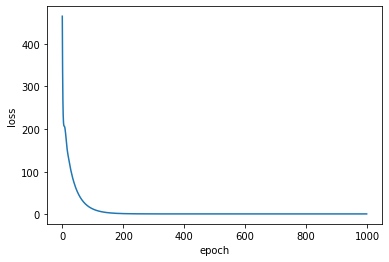

In [241]:
# create a manual seed for randomization
torch.manual_seed(41)
# Create an instance of our model
model = Model((2 * T_ini - 1)*input_dim, (n_basis), (n_basis + N*output_dim), (N)*output_dim)
# Set the criterion for our model to measure the error
criterion = nn.MSELoss()
# Choose Adam optimizer, lr = Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 1000
losses = []

for i in range(epochs):
    # Go forward and get a prediction
    y_pred = model.forward(X_train_1, X_train_2)  # get results
    #print(f"y_pred = {(y_pred).shape}")
    # Measure the loss/error,
    loss = criterion(y_pred, y_train)

    # keep track of our losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
        print(f"Epoch: {i} and the loss: {loss}")

    # Do some back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# create a plot
plt.plot(range(epochs), losses)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [22]:
with torch.no_grad():
    y_eval = model.forward(X_test_1, X_test_2)
type(y_test)

torch.Tensor

In [23]:
# evaluate the model on the test data set
with torch.no_grad():  # turn off backpropagation
    y_eval = model.forward(X_test_1, X_test_2)  # are features from our test set
    loss = criterion(y_eval, y_test)  # Find the loss or error

# print the predicted output and the test data
print(f"y_eval = {y_eval}")
print(f"y_test = {y_test}")
print(f"y_eval-y_test = {y_eval-y_test}")


print("test 1")

# Convert the model parameters to numpy arrays
centers = model.l_1.centers.detach().numpy()
log_sigmas = model.l_1.log_sigmas.detach().numpy()
weight = model.l_2.weight.detach().numpy()

print("test 2")
# save the parameters for use in matlab
# convert parameters to arrays so they can be saved as .mat files
centers = {"centers": centers}
log_sigmas = {"log_sigmas": log_sigmas}
weight = {"weight": weight}
X_test = {"X_test": X_test}
y_test = {"y_test": y_test}

print("test 3")

# save as .mat file

savemat(
    "centers.mat",
    centers,
)
savemat(
    "log_sigmas.mat",
    log_sigmas,
)
# savemat(r"weight.mat", weight)


print(f"u_data = {u_data}")
print(f"u_data.shape = {u_data.shape}")

y_eval = tensor([[ 8.4283,  8.4095,  8.3471,  ..., 11.3020, 11.5128, 11.5092],
        [ 9.0529,  8.6407,  8.2550,  ...,  7.9533,  7.9476,  7.6926],
        [ 6.9229,  7.2957,  7.3438,  ...,  7.6391,  7.8494,  7.9439],
        ...,
        [ 9.3137,  9.3323,  9.7093,  ...,  8.6996,  8.3664,  8.1072],
        [ 8.1576,  7.7687,  7.3755,  ..., 10.0901, 10.0231, 10.0516],
        [10.6082, 10.2215,  9.8215,  ...,  6.1205,  5.8879,  5.7541]])
y_test = tensor([[10.2403, 10.2323, 10.2131,  ..., 11.9206, 11.8583, 11.8331],
        [ 9.1248,  8.7204,  8.3327,  ...,  9.5331,  9.4153,  9.3180],
        [ 8.0153,  8.3757,  8.3641,  ...,  7.0795,  7.4915,  7.5017],
        ...,
        [ 7.6136,  7.6547,  8.0509,  ...,  8.2033,  7.8287,  7.8046],
        [ 9.7418,  9.3483,  8.9497,  ..., 11.9546, 11.9169, 11.8693],
        [ 7.3743,  7.0421,  6.7407,  ...,  6.0991,  5.7468,  5.3872]])
y_eval-y_test = tensor([[-1.8120, -1.8228, -1.8660,  ..., -0.6186, -0.3455, -0.3239],
        [-0.0720, -0.0797, -

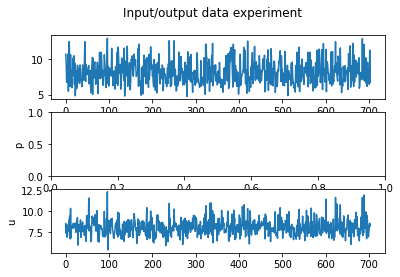

In [242]:
fig, axs = plt.subplots(3)
fig.suptitle("Input/output data experiment")
axs[0].plot(y_train[:,1])
#axs[1].plot(y_data[:,1])
axs[2].plot(y_pred[:,1].detach().numpy())
axs[1].set(ylabel="p")
#axs[1].set(ylabel="theta")
axs[2].set(ylabel="u")
plt.show()